# Notebook to test loading the aggregated references

In [1]:
import sys

#Ensure latest version of fsspec is used to allow simpletemplate=True of reference file system
sys.path.insert(0,'/home/jovyan/filesystem_spec')

In [2]:
import fsspec
import xarray as xr
import os, glob

In [3]:
fsspec.__file__

'/home/jovyan/filesystem_spec/fsspec/__init__.py'

In [4]:
gateway_cluster = True
from dask.distributed import Client, LocalCluster
from dask_gateway import Gateway

# Dask gateway
if gateway_cluster:
    gateway = Gateway()
    clusters = gateway.list_clusters()
    if not clusters:
        print('Creating new cluster. Please wait for this to finish.')
        options = gateway.cluster_options()
        options.worker_cores = 1
        options.worker_memory = 1.0
        cluster = gateway.new_cluster(cluster_options=options)
    else:
        print(f'An existing cluster was found. Connected to cluster \033[1m{clusters[0].name}\033[0m')
        cluster=gateway.connect(clusters[0].name)
#     cluster.adapt(minimum=1, maximum=30)
    cluster.scale(180)
    client = cluster.get_client()
    client.wait_for_workers(n_workers=180)

# Local cluster
else:
    cluster = LocalCluster()
    client = Client(cluster)

display(cluster)
display(client)

Creating new cluster. Please wait for this to finish.


Client Scheduler: gateway://traefik-dask-gateway.easihub:80/easihub.f0cb1ff40a9e491c8e36b27ba823f071 Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.f0cb1ff40a9e491c8e36b27ba823f071/status,Cluster Workers: 180 Cores: 180 Memory: 193.27 GB


## Opening the full stack in a delayed fashion is too slow (too many chunks for dask to compose) - need to subset and load each month using a different (single) thread

In [5]:
def open_and_crop(fo,
                  storage_options=dict(anon=True),
                  data_vars=['sea_surface_temperature','l2p_flags'],
                  cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.0,115.5)),
                  load=True,
                  simple_templates=True):
    
    mapper=fsspec.get_mapper('reference://',
                         fo=fo,
                         target_options=storage_options,
                         remote_protocol='s3',
                         remote_options=storage_options,
                        )
    ds = xr.open_zarr(mapper,chunks={'time':14})   

    ds = ds[data_vars]
    ds = ds.sel(**cropto)
    
    #Loading the data at this point causes issues with dask, due to task nesting - works OK using single-threaded, which makes sense
    if load:
        import dask
        with dask.config.set(scheduler='single-threaded'):
            try:
                ds = ds.load() #loads this months data
            except Exception as ex:
                print('Load Failed: ' + fo)
                return None
    
    return ds

In [6]:
def open_stack(s3_path,
               extension='json',
               storage_options=dict(anon=True),
               open_func=open_and_crop,
               open_kwargs={}):
    
    # Get the list of reference files
    fs = fsspec.filesystem('s3',**storage_options)
    agg_files = fs.glob(f'{s3_path}/*.{extension}')
    
    open_kwargs['storage_options']=storage_options
    
    from dask import compute, delayed
    d_open_dataset = delayed(open_func)
    futures = []
    for f in agg_files:
        futures.append(d_open_dataset('s3://' + f,**open_kwargs))
    dsets = compute(futures)[0]
    
    for i,ds in enumerate(dsets):
        if ds is None:
            print('Failed to open: ' + agg_files[i])
            
    dsets = [ds for ds in dsets if ds is not None]
    
    xarray_concat_kwargs = dict(dim='time',coords='minimal',join='override',compat='override',combine_attrs='override')
    ds = xr.concat(dsets, **xarray_concat_kwargs)
    ds = ds.sortby('time') # The sort is beneficial to re-order the data according to the coordinate, as having separate stacks for the different layouts breaks the ordering.
    
    return ds

In [7]:
# Load credentials
def load_creds():
    with open(os.environ['HOME'] + '/.aws/credentials','rt') as f:
        f.readline()
        key=f.readline().split('=')[1].strip()
        secret=f.readline().split('=')[1].strip()
    return key, secret
key,secret=load_creds()

### Monthly aggregates - load eagerly

#### Single point

In [8]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                extension='json',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,simple_templates=True,cropto=dict(lat=-32.,lon=115,method='nearest')))

CPU times: user 764 ms, sys: 24.8 ms, total: 789 ms
Wall time: 13.6 s


In [9]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                extension='zarr',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,simple_templates=True,cropto=dict(lat=-32.,lon=115,method='nearest')))

CPU times: user 621 ms, sys: 28.7 ms, total: 650 ms
Wall time: 12 s


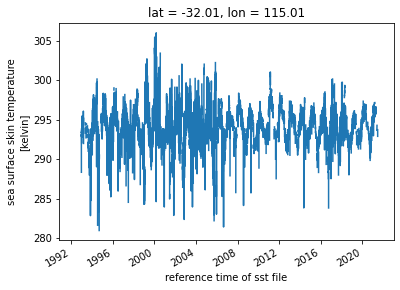

In [10]:
ds.sea_surface_temperature.plot()

#### 50km area

In [8]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                extension='json',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,
                                 simple_templates=True,
                                 cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.0,115.5))))

CPU times: user 1.2 s, sys: 185 ms, total: 1.39 s
Wall time: 17.9 s


In [10]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                extension='zarr',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,
                                 simple_templates=True,
                                 cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.0,115.5))))

CPU times: user 767 ms, sys: 99.2 ms, total: 867 ms
Wall time: 12.7 s


In [13]:
xr.set_options(display_style='text')
ds

<xarray.Dataset>
Dimensions:                  (lat: 25, lon: 25, time: 10576)
Coordinates:
  * lat                      (lat) float32 -32.01 -32.03 ... -32.47 -32.49
  * lon                      (lon) float32 115.0 115.0 115.1 ... 115.5 115.5
  * time                     (time) datetime64[ns] 1992-03-21T15:20:00 ... 20...
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 nan nan ... 291.3 290.6
    l2p_flags                (time, lat, lon) float32 nan nan ... 8.192e+03
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          Skin SST retrievals produced from stitc...
    time_coverage_end:                19920321T141620Z
    time_coverage_start:              19920321T055557Z
    title:                            IMOS L3S Nighttime gridded multiple-sen...
    uuid:                             1f323c53-8d93-4bb4-a633-49622aa4e497
    westernmost_longitude:            70.01000213623047

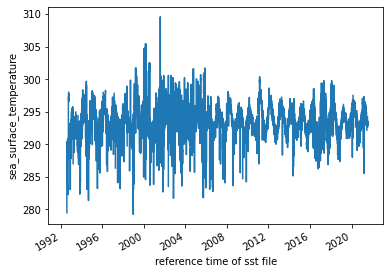

In [14]:
ds.sea_surface_temperature.stack(space=['lon','lat']).mean(dim='space').plot()

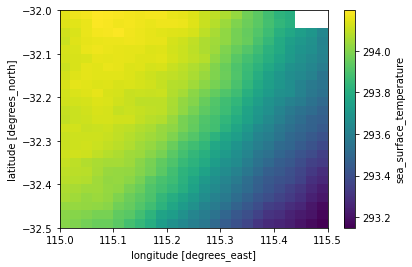

In [15]:
ds.sea_surface_temperature.mean(dim='time').plot()

### Monthly aggregates - open delayed and load distributed - slower

In [16]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=False,simple_templates=True))
ds = ds.chunk({'time':28})
# The graph is big, so takes the notebook and scheduler time to move around, much quicker to load eagerly the small payload
ds = ds.load()

CPU times: user 18 s, sys: 649 ms, total: 18.7 s
Wall time: 1min 31s


### Yearly aggregates - load eagerly - all slower
the large number templates means lots of time spent in str/jinja ops

In [17]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_yearly/',
                extension='json',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,simple_templates=True,cropto=dict(lat=-32.,lon=115,method='nearest')))

CPU times: user 126 ms, sys: 9.89 ms, total: 136 ms
Wall time: 42.6 s


In [18]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_yearly/',
                extension='json',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,
                                 simple_templates=True,
                                 cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.0,115.5))))

CPU times: user 221 ms, sys: 96.5 ms, total: 317 ms
Wall time: 41.7 s


In [11]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_yearly/',
                extension='zarr',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,
                                 cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.0,115.5))))

CPU times: user 257 ms, sys: 70 ms, total: 327 ms
Wall time: 36.6 s


### Yearly aggregates - open delayed and load distributed - slower

In [11]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_yearly/',
                extension='zarr',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=False,
                                 cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.0,115.5))))
ds = ds.load()

CPU times: user 42.9 s, sys: 765 ms, total: 43.6 s
Wall time: 3min 19s


In [20]:
cluster.shutdown()